<a href="https://colab.research.google.com/github/praseedm/tracin_implemention_on_ledgar_dataset/blob/main/Mislabelled_detection_using_self_influence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# clone git repo for data
! git clone https://github.com/praseedm/tracin_implemention_on_ledgar_dataset.git

Cloning into 'tracin_implemention_on_ledgar_dataset'...
remote: Enumerating objects: 69, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 69 (delta 31), reused 17 (delta 5), pack-reused 0
Unpacking objects: 100% (69/69), done.


In [2]:
# Mount GDrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd tracin_implemention_on_ledgar_dataset

/content/tracin_implemention_on_ledgar_dataset


In [4]:
# A dependency of the preprocessing for BERT inputs
!pip install -q -U "tensorflow-text==2.8.*"

     |████████████████████████████████| 4.9 MB 25.4 MB/s 
     |████████████████████████████████| 462 kB 15.8 MB/s 


In [5]:
# copying checkpoints 
!cp -r /content/drive/MyDrive/ARU/ML\ Project/train_outputs ./

In [22]:
import os

import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import tensorflow_text as text
import pandas as pd
import json
from tqdm import tqdm
import numpy as np
import random


tf.get_logger().setLevel('ERROR')

In [7]:
tf.__version__

'2.8.0'

## Data preparation

In [12]:
# Load labels 
with open('./data/label_names.json') as rb:
  label_names = json.load(rb)
print(f"Loaded {len(label_names)} labels")
print(f"Labels : {label_names}")

Loaded 25 labels
Labels : ['Amendments', 'Assignments', 'Compliance With Laws', 'Confidentiality', 'Counterparts', 'Entire Agreements', 'Expenses', 'Financial Statements', 'Further Assurances', 'General', 'Governing Laws', 'Indemnifications', 'Insurances', 'Litigations', 'No Conflicts', 'Notices', 'Payments', 'Severability', 'Survival', 'Taxes', 'Terminations', 'Terms', 'Use Of Proceeds', 'Waiver Of Jury Trials', 'Waivers']


In [8]:
BATCH_SIZE = 32
SEED = 10
AUTOTUNE = tf.data.AUTOTUNE

In [10]:
test_df = pd.read_csv('./data/test_data.csv')
test_df.head(3)

,text,label
0,Notwithstanding any other provision of this Ar...,2
1,Each Party (i) hereby agrees to instruct the a...,8
2,This Agreement may be executed in one or more ...,4


In [13]:
test_df.shape

(5438, 3)

### Radomly mislabel data

In [58]:
test_df['actual_label'] = test_df['label']
test_df.head(3)

,text,label,actual_label
0,Notwithstanding any other provision of this Ar...,2,2
1,Each Party (i) hereby agrees to instruct the a...,8,8
2,This Agreement may be executed in one or more ...,4,4


In [59]:
## Randomly mislabell 20% data
df_to_mislabel = test_df.sample(frac=0.2,random_state=SEED)
df_remaining = test_df.drop(df_to_mislabel.index)
print(df_to_mislabel.shape, df_remaining.shape)

(1088, 3) (4350, 3)


In [60]:
def choose_a_different_label(actual_label:int):
  labels = list(range(len(label_names)))
  labels.remove(actual_label)
  return random.choice(labels)

In [61]:
df_to_mislabel['label'] = df_to_mislabel['label'].apply(choose_a_different_label)

In [62]:
df_to_mislabel.head()

,text,label,actual_label
1109,"This Agreement, including its attached Exhibit...",15,5
5169,"All covenants, agreements, representations and...",19,18
4804,The term of your Option will expire at the clo...,12,21
5215,"The Class B Member, on the one hand, and the C...",1,24
4825,This Agreement shall be governed by and constr...,13,10


In [63]:
result_df = pd.concat([df_to_mislabel, df_remaining])
result_df.reset_index()
#shuffle df
result_df = result_df.sample(frac=1).reset_index(drop=True)
print(result_df.shape)
result_df.tail()

(5438, 3)


,text,label,actual_label
5433,The proceeds of the Loan funded at Closing sha...,20,22
5434,In consideration of the transfer of the Exchan...,16,16
5435,The Plan shall be governed by and construed in...,10,10
5436,Notices and all other communications contempla...,15,15
5437,This Agreement constitutes the entire agreemen...,5,5


In [64]:
def generate_batch_dataset_from_df(df):
  dataset = tf.data.Dataset.from_tensor_slices(
      (
          df['text'].values,
          df['label'].values,
          df['actual_label'].values
      )
  )
  print(f"{len(dataset)}\n{dataset.element_spec}")
  return dataset.batch(batch_size=BATCH_SIZE)

In [65]:
dataset = generate_batch_dataset_from_df(df=result_df)

5438
(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))


In [66]:
dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)

## Load checkpoints

In [40]:
checkpoints_root_dir = './train_outputs'
def get_checkpoint_dir(epoch_number:int):
  checkpoint_path = os.path.join(checkpoints_root_dir, f"mymodel_{epoch_number}")
  if os.path.exists(checkpoint_path):
    return checkpoint_path
  raise ValueError(f"{checkpoint_path} doesn't exists")


def load_model(model_path:str):
  print(f"Loading model from {model_path}")
  return tf.keras.models.load_model(model_path)

In [41]:
#load models
checkpoint_models = []
epochs = [2,4,5,6]
for epoch in tqdm(epochs):
  model_path = get_checkpoint_dir(epoch)
  checkpoint_models.append(load_model(model_path=model_path))

  0%|          | 0/4 [00:00<?, ?it/s]

Loading model from ./train_outputs/mymodel_2


 25%|██▌       | 1/4 [00:14<00:42, 14.05s/it]

Loading model from ./train_outputs/mymodel_4


 50%|█████     | 2/4 [00:30<00:31, 15.62s/it]

Loading model from ./train_outputs/mymodel_5


 75%|███████▌  | 3/4 [00:51<00:17, 17.98s/it]

Loading model from ./train_outputs/mymodel_6


100%|██████████| 4/4 [01:19<00:00, 19.88s/it]


## Run self influence

In [67]:
def compute_self_influence(inputs, models):
  # Refered from the TracIn, https://arxiv.org/pdf/2002.08484.pdf
  texts , labels, actual_labels = inputs
  self_influences = []
  for checkpoint_model in models:
    # picking weights from the last  two fully connected layer.
    with tf.GradientTape(watch_accessed_variables=False) as tape:
      tape.watch(checkpoint_model.trainable_weights[-2:])
      logits = checkpoint_model(texts)
      probs = tf.nn.softmax(logits)
      loss = tf.keras.losses.sparse_categorical_crossentropy(labels, probs)
    
    grads = tape.jacobian(loss, checkpoint_model.trainable_weights[-2:])
    scores = tf.add_n([tf.math.reduce_sum(
        grad * grad, axis=tf.range(1, tf.rank(grad), 1)) 
        for grad in grads])
    self_influences.append(scores)  

    probs, predicted_labels = tf.math.top_k(probs, k=1)
    return texts,  tf.math.reduce_sum(tf.stack(self_influences, axis=-1), axis=-1), labels, probs, predicted_labels, actual_labels
  

def run(dataset):
  texts = []
  scores = []
  labels = []
  predict_probs = []
  predict_labels = []
  actual_labels = []
  
  for batch in tqdm(dataset):
    b_texts , b_scores , b_labels, b_probs , b_predicted_labels, b_actual_labels = compute_self_influence(inputs=batch, models=checkpoint_models)
    texts.append(b_texts.numpy())
    scores.append(b_scores.numpy())
    labels.append(b_labels.numpy())
    predict_probs.append(b_probs.numpy())
    predict_labels.append(b_predicted_labels.numpy())
    actual_labels.append(b_actual_labels.numpy())
  
  return {
      'texts' : np.concatenate(texts),
      'self_influence_scores' : np.concatenate(scores),
      'labels' : np.concatenate(labels),
      'predicted_probs' : np.concatenate(predict_probs),
      'predicted_labels' : np.concatenate(predict_labels),
      'actual_labels' : np.concatenate(actual_labels)
  }


In [68]:
self_influece_result = run(dataset)

100%|██████████| 170/170 [08:21<00:00,  2.95s/it]


In [69]:
def get_label_name_from_index(index):
  return label_names[index]

def save_result(self_incluence_features, topk=10):
  sorted_indices = np.argsort(-self_incluence_features['self_influence_scores'])
  result = []
  for index in sorted_indices[:topk]:
    result.append(
        {
            "text" : self_incluence_features['texts'][index],
            "label" : get_label_name_from_index(self_incluence_features['labels'][index]),
            "predicted_label" : get_label_name_from_index(self_incluence_features['predicted_labels'][index][0]),
            "confidence" : self_incluence_features['predicted_probs'][index][0],
            "self_influence_score" : self_incluence_features['self_influence_scores'][index],
            "actual_label" : get_label_name_from_index(self_incluence_features['actual_labels'][index])
        }
    )
  
  return result

In [93]:
self_influence_result_df = pd.DataFrame(save_result(self_influece_result,topk=5438))

In [94]:
self_influence_result_df.head(5)

,text,label,predicted_label,confidence,self_influence_score,actual_label
0,b'The Company shall pay all costs and expenses...,Indemnifications,Expenses,0.991468,483.788849,Expenses
1,b'The costs and expenses of each Party (includ...,Waiver Of Jury Trials,Expenses,0.994192,477.528625,Expenses
2,b'The Company shall reimburse Executive for al...,Waiver Of Jury Trials,Expenses,0.987058,471.744934,Expenses
3,b'The Investor shall be responsible for its ow...,Governing Laws,Expenses,0.993522,469.615479,Expenses
4,b'Each of the Company and the Selling Stockhol...,Terminations,Expenses,0.991494,466.213684,Expenses


In [95]:
actual_mislabelled = []
predicted_mislabelled = []

for index, row in self_influence_result_df.iterrows():
  label = row['label']
  predicted_label = row['predicted_label']
  actual_label = row['actual_label']
  actual_mislabelled.append(int(label != actual_label ))
  # whether model detected the mislabelled
  predicted_mislabelled.append( int (label != predicted_label) )


self_influence_result_df['actual_mislabelled'] = actual_mislabelled
self_influence_result_df['predicted_mislabelled'] = predicted_mislabelled

In [96]:
self_influence_result_df.head(3)

,text,label,predicted_label,confidence,self_influence_score,actual_label,actual_mislabelled,predicted_mislabelled
0,b'The Company shall pay all costs and expenses...,Indemnifications,Expenses,0.991468,483.788849,Expenses,1,1
1,b'The costs and expenses of each Party (includ...,Waiver Of Jury Trials,Expenses,0.994192,477.528625,Expenses,1,1
2,b'The Company shall reimburse Executive for al...,Waiver Of Jury Trials,Expenses,0.987058,471.744934,Expenses,1,1


In [97]:
self_influence_result_df['actual_mislabelled'].value_counts()

0    4350
1    1088
Name: actual_mislabelled, dtype: int64

In [98]:
self_influence_result_df['predicted_mislabelled'].value_counts()

0    4109
1    1329
Name: predicted_mislabelled, dtype: int64

In [73]:

from sklearn.metrics import confusion_matrix

In [99]:
cf_matrix = confusion_matrix(actual_mislabelled, predicted_mislabelled)

In [100]:
cf_matrix

array([[4105,  245],
       [   4, 1084]])

In [101]:
import seaborn as sns

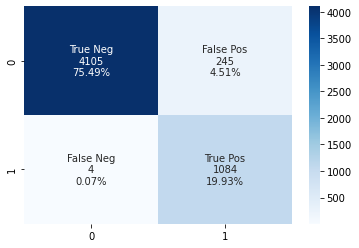

In [104]:
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [86]:
1084 / 1088

83.53999999999999

In [87]:
16.33 + 0.13

16.459999999999997

In [88]:
1084 / 1088

0.9963235294117647